In [3]:
%pwd

'/content'

In [4]:
from google.colab import drive
drive.mount('../content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wGB-iGec1pRmPn85D2Uy0Hm5hP1J5nHIDPbVmtt0JuBHAjjjP0NXC4
Mounted at ../content/drive


# 바꿔야할 부분
※ 경로

In [5]:
cd ../content/drive/My Drive/Pytorch/CNN

/content/drive/My Drive/Pytorch/CNN


In [6]:
''' import libraries '''

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms  # 1 batch = (1, 784)
from torchvision.datasets import MNIST
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from torchsummary import summary

In [8]:
# torch.device
print("is there cuda? :",  torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

is there cuda? : True
cuda:0


In [9]:
''' data load '''
download_root = '../data'
# Normalize data with mean=0.5, std=1.0
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(1.0,))
])

# 60000 if train=True, 60000. else 10000.
train_data = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_data = MNIST(download_root, transform=mnist_transform, train=False, download=True)

# 위 데이터를 batch size로 나눴구나
batch_size = 50
# 938 = int(60000/batch_size)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# if you wanna pick one sample
# example_mini_batch_img, example_mini_batch_label  = next(iter(train_loader))
# print(example_mini_batch_img.shape)  # torch.Size([batch_size, 1, 28, 28])

In [11]:
''' Build Network, CNN '''
class CNN_Net(nn.Module):
    def __init__(self, p=0.0):
        super(CNN_Net, self).__init__()

        # MNIST 는 정형화되어있잖아, 직사각형 input도 다뤄볼 줄 알아야해.

        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        self.before_fc1 = nn.Linear(4 * 4 * 128, 625, bias=True) # 계산하는거 맞네!
        nn.init.xavier_uniform_(self.before_fc1.weight)

        # FC1 4x4x128 inputs -> 625 outputs
        self.fc1 = nn.Sequential(
            self.before_fc1,  
            nn.ReLU(),
            nn.Dropout(p=p))
        
        # FC2 625 inputs -> 10 outputs
        self.fc2 = nn.Linear(625, 10, bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = x.float()
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)

        out = nn.LogSoftmax(dim=-1)(out)
        return out

In [12]:
''' hyper parameters '''
# total_batch_num = int(len(train_data) / batch_size)
epochs = 20
lr = 0.001
print_interval = 100
drop_prob = 0.2 # 0.2 # 0=적용 안함. -> 모델에서도 빼줌..

# model, optimizer 초기화
model = CNN_Net(p=drop_prob).to(device)  # train 코드에서 모듈 model 호출될 때마다 forward 자동 실행!
optimizer = optim.Adam(model.parameters(), lr=lr)

In [13]:
cnt = 0
num_test_img = 1
for batch_idx, (x, target) in enumerate(test_loader):  
    if batch_idx > 0 : # 일부만 확인할거임
        break
    for b in range(batch_size):
        if cnt >= num_test_img :
            break
        img = x[b]
        print(img.size())
        cnt += 1

torch.Size([1, 28, 28])


In [14]:
summary(model,input_size=(1, 28, 28))  # input_size=(channels, H, W) -> DNN이랑 달라?

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
              ReLU-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 625]       1,280,625
           Linear-11                  [-1, 625]       1,280,625
             ReLU-12                  [-1, 625]               0
          Dropout-13                  [-1, 625]               0
           Linear-14                   

In [15]:
# 모델의 state_dict 출력
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    # model.state_dict()[param_tensor].dat => 접근가능하네!
# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

conv_layer1.0.weight 	 torch.Size([32, 1, 3, 3])
conv_layer1.0.bias 	 torch.Size([32])
conv_layer2.0.weight 	 torch.Size([64, 32, 3, 3])
conv_layer2.0.bias 	 torch.Size([64])
conv_layer3.0.weight 	 torch.Size([128, 64, 3, 3])
conv_layer3.0.bias 	 torch.Size([128])
before_fc1.weight 	 torch.Size([625, 2048])
before_fc1.bias 	 torch.Size([625])
fc1.0.weight 	 torch.Size([625, 2048])
fc1.0.bias 	 torch.Size([625])
fc2.weight 	 torch.Size([10, 625])
fc2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


train_batch_num:  1200
x.shape torch.Size([50, 1, 28, 28]) target.shape torch.Size([50])
60000
epoch: 0	batch Step: 0	Loss: 0.133	Accuracy: 98.000
epoch: 0	batch Step: 100	Loss: 0.352	Accuracy: 94.000
epoch: 0	batch Step: 200	Loss: 0.040	Accuracy: 100.000
epoch: 0	batch Step: 300	Loss: 0.036	Accuracy: 100.000
epoch: 0	batch Step: 400	Loss: 0.180	Accuracy: 98.000
epoch: 0	batch Step: 500	Loss: 0.101	Accuracy: 98.000
epoch: 0	batch Step: 600	Loss: 0.065	Accuracy: 98.000
epoch: 0	batch Step: 700	Loss: 0.105	Accuracy: 98.000
epoch: 0	batch Step: 800	Loss: 0.005	Accuracy: 100.000
epoch: 0	batch Step: 900	Loss: 0.006	Accuracy: 100.000
epoch: 0	batch Step: 1000	Loss: 0.017	Accuracy: 100.000
epoch: 0	batch Step: 1100	Loss: 0.280	Accuracy: 94.000
train_batch_num:  1200
x.shape torch.Size([50, 1, 28, 28]) target.shape torch.Size([50])
60000
epoch: 1	batch Step: 0	Loss: 0.006	Accuracy: 100.000
epoch: 1	batch Step: 100	Loss: 0.003	Accuracy: 100.000
epoch: 1	batch Step: 200	Loss: 0.034	Accuracy: 10

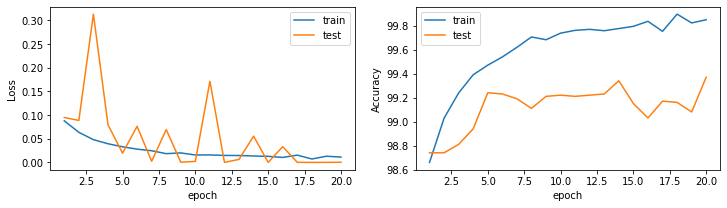

In [17]:
# 통일성 있게 코드 짜자.
train_epoch_loss = []
train_epoch_acc = []
test_epoch_loss = []
test_epoch_acc = []

for epoch in range(epochs):

    ''' Train '''
    model.train()
    train_batch_loss = []
    train_batch_acc = []
    train_batch_num = len(train_loader)
    print("train_batch_num: ", train_batch_num)
    for batch_idx, (x, target) in enumerate(train_loader):
        if batch_idx == 0:
            print('x.shape', x.shape, 'target.shape', target.shape)  # torch.Size([64, 1, 28, 28]) torch.Size([64])
            print(len(train_loader.dataset))  # 60000

        x, target = Variable(x).to(device), Variable(target).to(device)
        
        optimizer.zero_grad()
        output = model(x)
        loss = F.nll_loss(output, target).to(device)
        
        loss.backward()    # calc gradients
        train_batch_loss.append(loss.item()/batch_size*100) # from tensor -> get value loss.item() or loss.data
        optimizer.step()   # update gradients
        prediction = output.argmax(dim=1, keepdims=True)
        accuracy = torch.true_divide(prediction.eq(target.view_as(prediction)).sum().data, batch_size)*100
        train_batch_acc.append(accuracy)
        if batch_idx % print_interval == 0:
            print('epoch: {}\tbatch Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(
                    epoch, batch_idx, train_batch_loss[batch_idx], train_batch_acc[batch_idx]))

    train_epoch_loss.append(np.sum(train_batch_loss)/train_batch_num)
    train_epoch_acc.append(np.sum(train_batch_acc)/train_batch_num)


    ''' Test '''
    model.eval()
    test_batch_loss = []
    test_batch_acc = []
    test_batch_num = len(test_loader)

    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_loader):

            x, target = Variable(x).to(device), Variable(target).to(device)
            output = model(x)
            test_batch_loss.append(loss.item()/batch_size*100)
            prediction = output.argmax(dim=1, keepdims=True)
            accuracy = torch.true_divide(prediction.eq(target.view_as(prediction)).sum().data, batch_size)*100
            test_batch_acc.append(accuracy)

    test_epoch_loss.append(np.sum(test_batch_loss)/test_batch_num)
    test_epoch_acc.append(np.sum(test_batch_acc)/test_batch_num)


''' save results to numpy '''
train_test_result = (train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc)
np.save("result.npy", train_test_result)

print("==================================")
print("train_epoch_loss:", train_epoch_loss)
print("test_epoch_loss:", test_epoch_loss)
print("train_epoch_acc", train_epoch_acc)
print("test_epoch_acc", test_epoch_acc)
print("==================================")
x = np.arange(start=1, stop=len(train_epoch_loss)+1, step=1)

fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(x, train_epoch_loss, label='train')
plt.plot(x, test_epoch_loss, label='test')
ax1.legend()
ax1.set(ylabel="Loss", xlabel='epoch')

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(x, train_epoch_acc, label='train')
plt.plot(x, test_epoch_acc, label='test')
ax2.legend()
ax2.set(ylabel="Accuracy", xlabel='epoch')

plt.show()

# ''' inference를 위한 모델 저장  '''
model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
model_name = "./CNN"
option = 2

if option == 0:
    model_path = model_name + '_all.pt'
    torch.save(model, model_path)

elif option == 1:
    model_path = model_name + '_state_dict.pt'
    torch.save(model.state_dict, model_path)

elif option == 2:
    model_path = model_name + '_ckp.tar'
    torch.save({
            'last_epoch': epochs -1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, model_path)
    

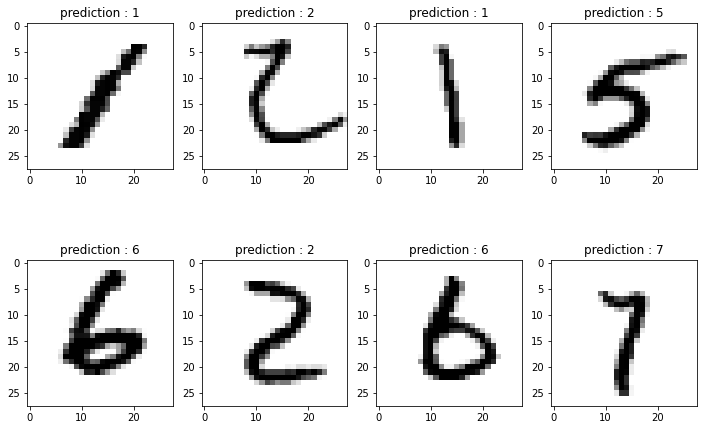

In [ ]:
''' 모델 불러오기 '''

model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
model_name = "./CNN"
option = 2

if option == 0:
    # 모델 클래스는 어딘가에 반드시 선언되어 있어야 합니다
    model_path = model_name + '_all.pt'
    model = torch.load(model_path)

elif option == 1:
    model_path = model_name + '_state_dict.pt'
    model = CNN_Net()
    model.load_state_dict(torch.load(model_path))

elif option == 2:
    # model, optimizer 초기화
    model = CNN_Net()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model_path = model_name + '_ckp.tar'
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['last_epoch']
    loss = checkpoint['loss']


''' Plot Test '''
model.eval()
test_batch_loss = []
test_batch_acc = []
test_batch_num = len(test_loader)

num_test_img = 8
cnt = 0
fig_test = plt.figure(figsize=(12, 8))
with torch.no_grad():
    for batch_idx, (x, target) in enumerate(test_loader):  
        if batch_idx > 0 : # 일부만 확인할거임
            break
        for b in range(batch_size):
            if cnt >= num_test_img :
                break
            img = x[b]
            output = model(img)
            prediction = output.argmax(dim=1, keepdims = False).item()
            subplt = fig_test.add_subplot(2, 4, b + 1)
            subplt.set_title("prediction : %d" % prediction)
            subplt.imshow(img.reshape((28, 28)), cmap=plt.cm.gray_r)

            cnt += 1
plt.show()


In [ ]:
'''trainable parameter 확인'''
param_dict = {}
for param_tensor in model.state_dict():
    param_dict[param_tensor] = model.state_dict()[param_tensor]
    print(param_tensor, model.state_dict()[param_tensor].size())

print("========================")
print(param_dict)

fc1.weight torch.Size([512, 784])
fc1.bias torch.Size([512])
fc2.weight torch.Size([256, 512])
fc2.bias torch.Size([256])
fc3.weight torch.Size([128, 256])
fc3.bias torch.Size([128])
fc4.weight torch.Size([64, 128])
fc4.bias torch.Size([64])
fc5.weight torch.Size([32, 64])
fc5.bias torch.Size([32])
fc6.weight torch.Size([10, 32])
fc6.bias torch.Size([10])
{'fc1.weight': tensor([[ 0.0178, -0.0313,  0.0153,  ...,  0.0320, -0.0134, -0.0018],
        [ 0.0103, -0.0084,  0.0005,  ...,  0.0436, -0.0225,  0.0307],
        [-0.0057,  0.0106, -0.0169,  ...,  0.0303,  0.0247,  0.0242],
        ...,
        [-0.0181, -0.0010, -0.0074,  ..., -0.0161, -0.0292, -0.0012],
        [-0.0268, -0.0010, -0.0125,  ...,  0.0367,  0.0395, -0.0041],
        [ 0.0048,  0.0135,  0.0201,  ...,  0.0145,  0.0290,  0.0299]]), 'fc1.bias': tensor([ 2.7251e-02, -1.0061e-02, -2.5854e-02,  6.2849e-03,  1.5628e-02,
         2.3756e-02, -6.7040e-03,  5.9113e-03, -1.6234e-02, -1.7354e-02,
        -1.4856e-02, -2.3461e-02, 